# Выбор локации для скважины

**Задача проекта:**

На основе данных  геологоразведки трёх регионов, представленных в файлах:
1. /datasets/geo_data_0.csv
2. /datasets/geo_data_1.csv
3. /datasets/geo_data_2.csv
* id — уникальный идентификатор скважины
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
* product — объём запасов в скважине (тыс. баррелей)


**Построить модель** для определения региона, где добыча принесёт наибольшую прибыль

**Проанализировать возможную прибыль и риски** техникой Bootstrap

В каждом регионе 100 000 месторождений.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка и проверка данных

In [1]:
# загружем библиотеки и подготавливаем рабочее пространство

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

from numpy.random import RandomState
RANDOM_STATE = RandomState(0)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
# загружаем файлы
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# читаем первые 5 строк
display(data_1.head(5))
display(data_2.head(5))
display(data_3.head(5))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
# выводим общую информацию о файлах
data_1.info()
print()
data_2.info()
print()
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

In [5]:
# проверяем наличие полных дубликатов
print('Количество полных дубликатов_регион1:\n', data_1.duplicated().sum())
print()
print('Количество полных дубликатов_регион2:\n', data_2.duplicated().sum())
print()
print('Количество полных дубликатов_регион3:\n', data_3.duplicated().sum())

Количество полных дубликатов_регион1:
 0

Количество полных дубликатов_регион2:
 0

Количество полных дубликатов_регион3:
 0


#### Выводы:
* каждый файл содержит 100 000 записей, что соответствует кол-ву месторождений в каждом исследуемом регионе
* данные записаны в ожидаемых форматах
* пропущенные значения не обнаружены
* полные дубликаты не обнаружены

### EDA

#### параметр id

In [6]:
# проверяем уникальность id записи,
# регион 1
data_1.id.nunique()

99990

In [7]:
# выводим объекты с неуникальным id,
# регион 1
id_not_unique_r1 = data_1.groupby('id')['id'].value_counts().sort_values(ascending=False).head(10).unstack()
data_1_not_unique = data_1[data_1['id'].isin(id_not_unique_r1.index)].sort_values(by=['id', 'product'])
display(data_1_not_unique.index)
display(data_1_not_unique)

Int64Index([66136, 64022, 51970,  3389, 69163, 42529,   931,  7530, 63593,
             1949, 75715, 21426, 60140, 92341, 97785, 89582,  1364, 41724,
            16633, 90815],
           dtype='int64')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [8]:
# удаляем объекты с задублированными id
data_1 = data_1.drop([66136, 64022, 51970,  3389, 69163, 42529,   931,  7530, 63593,
             1949, 75715, 21426, 60140, 92341, 97785, 89582,  1364, 41724,
            16633, 90815])
data_1.shape

(99980, 5)

In [9]:
# проверяем уникальность id записи,
# регион 2
data_2.id.nunique()

99996

In [10]:
# выводим объекты с неуникальным id,
# регион 2
id_not_unique_r2 = data_2.groupby('id')['id'].value_counts().sort_values(ascending=False).head(4).unstack()
data_2_not_unique = data_2[data_2['id'].isin(id_not_unique_r2.index)].sort_values(by=['id', 'product'])
display(data_2_not_unique.index)
display(data_2_not_unique)

Int64Index([5849, 84461, 41906, 1305, 82178, 2721, 47591, 82873], dtype='int64')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [11]:
# удаляем объекты с задублированными id
data_2 = data_2.drop([5849, 84461, 41906, 1305, 82178, 2721, 47591, 82873])
data_2.shape

(99992, 5)

In [12]:
# проверяем уникальность id записи,
# регион 3
data_3.id.nunique()

99996

In [13]:
# выводим объекты с неуникальным id,
# регион 3
id_not_unique_r3 = data_3.groupby('id')['id'].value_counts().sort_values(ascending=False).head(4).unstack()
data_3_not_unique = data_3[data_3['id'].isin(id_not_unique_r3.index)].sort_values(by=['id', 'product'])
display(data_3_not_unique.index)
display(data_3_not_unique)

Int64Index([45404, 55967, 49564, 11449, 95090, 44378, 28039, 43233], dtype='int64')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [14]:
# удаляем объекты с задублированными id
data_3 = data_3.drop([45404, 55967, 49564, 11449, 95090, 44378, 28039, 43233])
data_3.shape

(99992, 5)

##### Выводы
* анализ параметра id выявил задублированные объекты во всех 3-х датасетах:
>
> data_1 = 20 объектов
>
> data_2 = 8 объектов
>
> data_3 = 8 объектов
>
* разница между данными по целевой переменной и параметрам в каждом из дублей является существенной
* в датасетах не прослеживается логика, позволяющая сделать выводы об истинной записи в дублях
* в связи с несущественном количеством данных дублей принято решение об удалении объектов

#### параметр f0

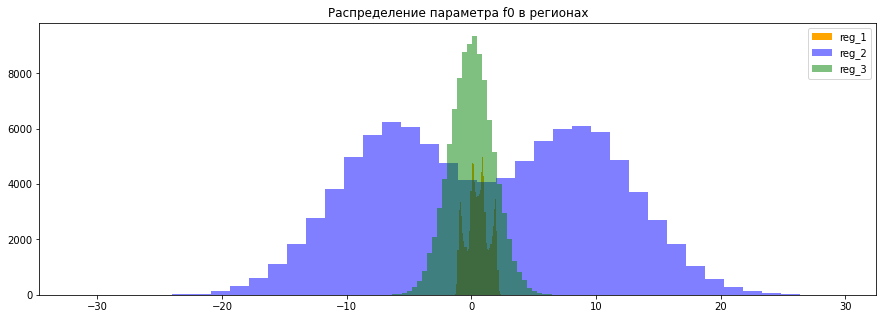

In [15]:
# строим гистограммы распределения данных по парметру f0 в регионах
plt.figure(figsize=(15, 5))
plt.hist(data_1.f0, color='orange', alpha = 1, bins = 40, label = 'reg_1')
plt.hist(data_2.f0, color = 'blue', alpha = 0.5, bins = 40, label = 'reg_2')
plt.hist(data_3.f0, color = 'green', alpha = 0.5, bins = 40, label = 'reg_3')
plt.title('Распределение параметра f0 в регионах')
plt.legend()
plt.show()

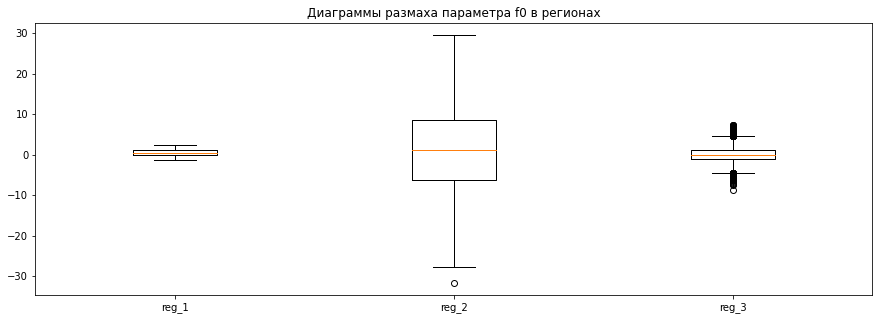

In [16]:
# строим диаграммы размаха данных по парметру f0 в регионах
plt.figure(figsize=(15, 5))
x1 = data_1.f0
x2 = data_2.f0
x3 = data_3.f0
plt.boxplot([x1, x2, x3], labels = ['reg_1', 'reg_2', 'reg_3'])
plt.title('Диаграммы размаха параметра f0 в регионах')
plt.show()

In [17]:
# выводим стат данные по параметру f0 в регионах
statistics_f0_r1 = data_1.f0.describe().to_frame()
statistics_f0_r2 = data_2.f0.describe().to_frame()
statistics_f0_r3 = data_3.f0.describe().to_frame()
statistics_f0 = statistics_f0_r1.join(statistics_f0_r2, rsuffix="_reg_2").join(statistics_f0_r3, rsuffix="_reg_3")
display(statistics_f0)

,f0,f0_reg_2,f0_reg_3
count,99980.000000,99992.000000,99992.000000
mean,0.500447,1.141363,0.001975
std,0.871879,8.965805,1.732061
min,-1.408605,-31.609576,-8.760004
25%,-0.072674,-6.298525,-1.162328
50%,0.502374,1.153190,0.009411
75%,1.073692,8.620964,1.158442
max,2.362331,29.421755,7.238262


##### Выводы
* данные по параметру **f0** в **регионе 1** имеют 4-х модальное распределение, напоминающее форму нормального, не имеют выбросов, среднее и медиана совпадают, стандартное отклонение минимально
* данные по параметру **f0** в **регионе 2** имеют 2-х модальное распределение, зеркально отраженное относительно 0, не имеют выбросов, среднее и медиана близки, максимальный разброс между минимальным и максимальным значениями, максимальное стандартное отклонение
* данные по параметру **f0** в **регионе 3** имеют нормальное распределение, выбросы слева и справа
* принято решение удалить выбросы по параметру f0 в данных по 3-му региону для дальнейшего повышения качества модели

In [18]:
# создаем функцию для удаления выбросов,
# принимаем за выбросы значения больше / меньше 1.5 межквартильного размаха
def remove_outliers(data, column):
    q25 = np.array(data[column].quantile(0.25))
    q75 = np.array(data[column].quantile(0.75))
    first_part = q25 - 1.5 * (q75 - q25)
    second_part = q75 + 1.5 * (q75 - q25)
    del_index = []
    for index_value, value in zip(data[column].index, data[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество объектов, выбранных для удаления: ', len(del_index))
    print('Процент удаленных объектов: ', len(del_index)*100 / 100000)
    return del_index

In [19]:
# удаляем выбросы по параметру f0 в регионе 3
indexes = remove_outliers(data_3, 'f0')
data_3.drop(indexes ,axis = 0, inplace = True)

Количество объектов, выбранных для удаления:  733
Процент удаленных объектов:  0.733


#### параметр f1

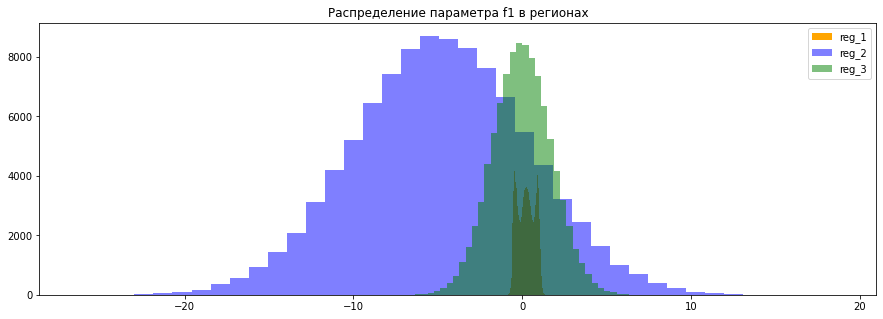

In [20]:
# строим гистограммы распределения данных по парметру f1 в регионах
plt.figure(figsize=(15, 5))
plt.hist(data_1.f1, color='orange', alpha = 1, bins = 40, label = 'reg_1')
plt.hist(data_2.f1, color = 'blue', alpha = 0.5, bins = 40, label = 'reg_2')
plt.hist(data_3.f1, color = 'green', alpha = 0.5, bins = 40, label = 'reg_3')
plt.title('Распределение параметра f1 в регионах')
plt.legend()
plt.show()

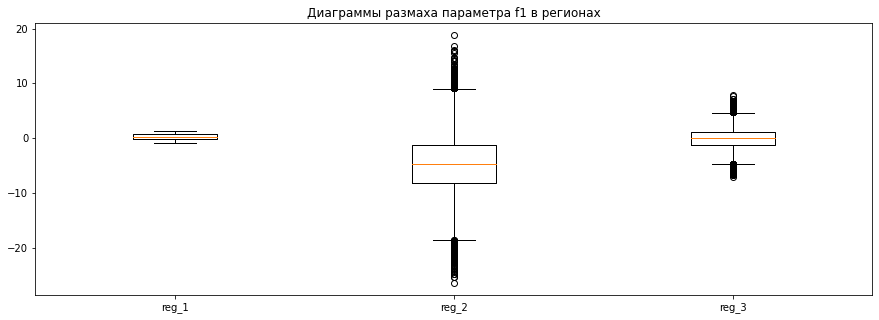

In [21]:
# строим диаграммы размаха данных по парметру f1 в регионах
plt.figure(figsize=(15, 5))
x1 = data_1.f1
x2 = data_2.f1
x3 = data_3.f1
plt.boxplot([x1, x2, x3], labels = ['reg_1', 'reg_2', 'reg_3'])
plt.title('Диаграммы размаха параметра f1 в регионах')
plt.show()

In [22]:
# выводим стат данные по параметру f1 в регионах
statistics_f1_r1 = data_1.f1.describe().to_frame()
statistics_f1_r2 = data_2.f1.describe().to_frame()
statistics_f1_r3 = data_3.f1.describe().to_frame()
statistics_f1 = statistics_f1_r1.join(statistics_f1_r2, rsuffix="_reg_2").join(statistics_f1_r3, rsuffix="_reg_3")
display(statistics_f1)

,f1,f1_reg_2,f1_reg_3
count,99980.000000,99992.000000,99259.000000
mean,0.250147,-4.796522,-0.001823
std,0.504431,5.119934,1.730527
min,-0.848218,-26.358598,-7.084020
25%,-0.200869,-8.267985,-1.174409
50%,0.250252,-4.813005,-0.009345
75%,0.700646,-1.332704,1.163764
max,1.343769,18.734063,7.844801


##### Выводы
* данные по параметру **f1** в **регионе 1** имеют 3-х модальное распределение, напоминающее форму нормального, не имеют выбросов, среднее и медиана совпадают, стандартное отклонение минимально
* данные по параметру **f1** в **регионе 2** имеют форму нормального распределения, выбросы слева и справа, среднее и медиана близки, максимальный разброс между минимальным и максимальным значениями, максимальное стандартное отклонение
* данные по параметру **f1** в **регионе 3** имеют нормальное распределение, выбросы слева и справа
* принято решение удалить выбросы по параметру f1 в данных по 2-му и 3-му регионам для дальнейшего повышения качества модели

In [23]:
# удаляем выбросы по параметру f1 в регионе 2
indexes = remove_outliers(data_2, 'f1')
data_2.drop(indexes ,axis = 0, inplace = True)

Количество объектов, выбранных для удаления:  636
Процент удаленных объектов:  0.636


In [24]:
# удаляем выбросы по параметру f1 в регионе 3
indexes = remove_outliers(data_3, 'f1')
data_3.drop(indexes ,axis = 0, inplace = True)

Количество объектов, выбранных для удаления:  682
Процент удаленных объектов:  0.682


#### параметр f2

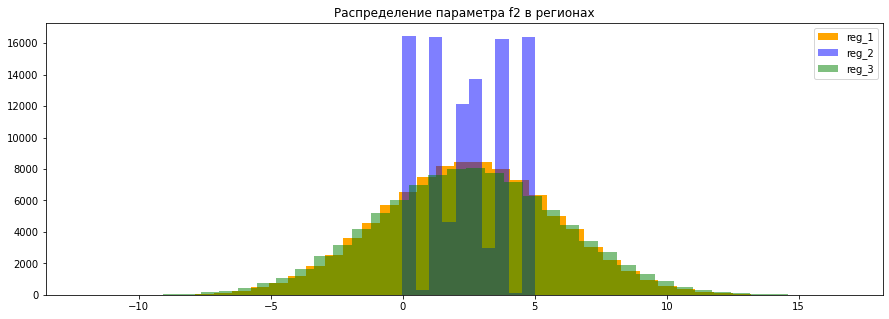

In [25]:
# строим гистограммы распределения данных по парметру f2 в регионах
plt.figure(figsize=(15, 5))
plt.hist(data_1.f2, color='orange', alpha = 1, bins = 40, label = 'reg_1')
plt.hist(data_2.f2, color = 'blue', alpha = 0.5, bins = 10, label = 'reg_2')
plt.hist(data_3.f2, color = 'green', alpha = 0.5, bins = 40, label = 'reg_3')
plt.title('Распределение параметра f2 в регионах')
plt.legend()
plt.show()

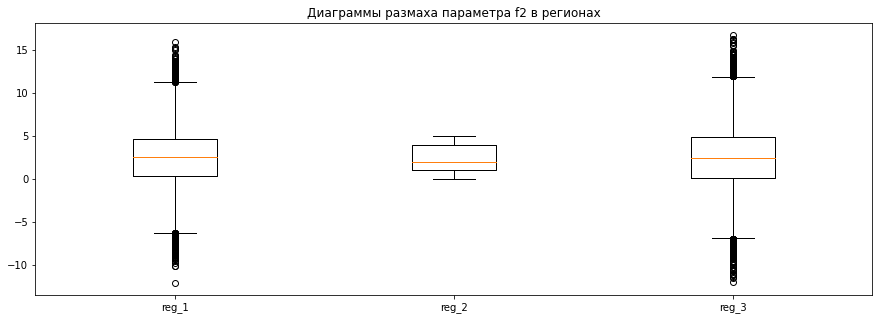

In [26]:
# строим диаграммы размаха данных по парметру f2 в регионах
plt.figure(figsize=(15, 5))
x1 = data_1.f2
x2 = data_2.f2
x3 = data_3.f2
plt.boxplot([x1, x2, x3], labels = ['reg_1', 'reg_2', 'reg_3'])
plt.title('Диаграммы размаха параметра f2 в регионах')
plt.show()

In [27]:
# выводим стат данные по параметру f2 в регионах
statistics_f2_r1 = data_1.f2.describe().to_frame()
statistics_f2_r2 = data_2.f2.describe().to_frame()
statistics_f2_r3 = data_3.f2.describe().to_frame()
statistics_f2 = statistics_f2_r1.join(statistics_f2_r2, rsuffix="_reg_2").join(statistics_f2_r3, rsuffix="_reg_3")
display(statistics_f1)

,f1,f1_reg_2,f1_reg_3
count,99980.000000,99992.000000,99259.000000
mean,0.250147,-4.796522,-0.001823
std,0.504431,5.119934,1.730527
min,-0.848218,-26.358598,-7.084020
25%,-0.200869,-8.267985,-1.174409
50%,0.250252,-4.813005,-0.009345
75%,0.700646,-1.332704,1.163764
max,1.343769,18.734063,7.844801


##### Выводы
* данные по параметру **f2** в **регионе 1** имеют форму нормального распределения, выбросы слева и справа, среднее и медиана совпадают, стандартное отклонение минимально
* данные по параметру **f2** в **регионе 2** имеют форму не нормального распределения, 5 мод, выбросы отсутствуют, среднее и медиана близки, максимальный разброс между минимальным и максимальным значениями, максимальное стандартное отклонение
* данные по параметру **f2** в **регионе 3** имеют форму нормального распределения, выбросы слева и справа
* принято решение удалить выбросы по параметру f2 в данных по 1-му и 3-му регионам для дальнейшего повышения качества модели

In [28]:
# удаляем выбросы по параметру f2 в регионе 1
indexes = remove_outliers(data_1, 'f2')
data_1.drop(indexes ,axis = 0, inplace = True)

Количество объектов, выбранных для удаления:  507
Процент удаленных объектов:  0.507


In [29]:
# удаляем выбросы по параметру f2 в регионе 3
indexes = remove_outliers(data_3, 'f2')
data_3.drop(indexes ,axis = 0, inplace = True)

Количество объектов, выбранных для удаления:  582
Процент удаленных объектов:  0.582


#### целевая переменная product

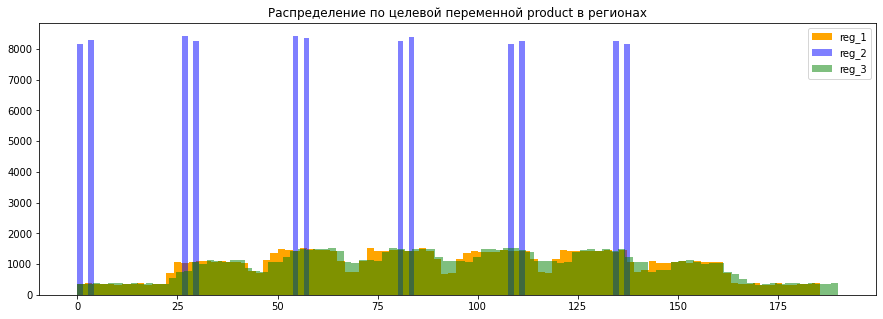

In [30]:
# строим гистограммы распределения данных по целевой переменной product в регионах
plt.figure(figsize=(15, 5))
plt.hist(data_1['product'], color='orange', alpha = 1, bins = 100, label = 'reg_1')
plt.hist(data_2['product'], color = 'blue', alpha = 0.5, bins = 100, label = 'reg_2')
plt.hist(data_3['product'], color = 'green', alpha = 0.5, bins = 100, label = 'reg_3')
plt.title('Распределение по целевой переменной product в регионах')
plt.legend()
plt.show()

In [31]:
# выводим стат данные по целевой переменной product в регионах
statistics_product_r1 = data_1['product'].describe().to_frame()
statistics_product_r2 = data_2['product'].describe().to_frame()
statistics_product_r3 = data_3['product'].describe().to_frame()
statistics_product = statistics_product_r1.join(statistics_product_r2, rsuffix="_reg_2")\
.join(statistics_product_r3, rsuffix="_reg_3")
display(statistics_product)

,product,product_reg_2,product_reg_3
count,99473.000000,99356.000000,97995.000000
mean,92.500765,68.809060,94.783796
std,44.228930,45.935409,44.683066
min,0.000000,0.000000,0.000000
25%,56.565401,26.953261,59.330119
50%,91.842280,57.085625,94.695386
75%,128.518797,107.813044,130.317309
max,185.364347,137.945408,190.029838


#### определение зависисмостей

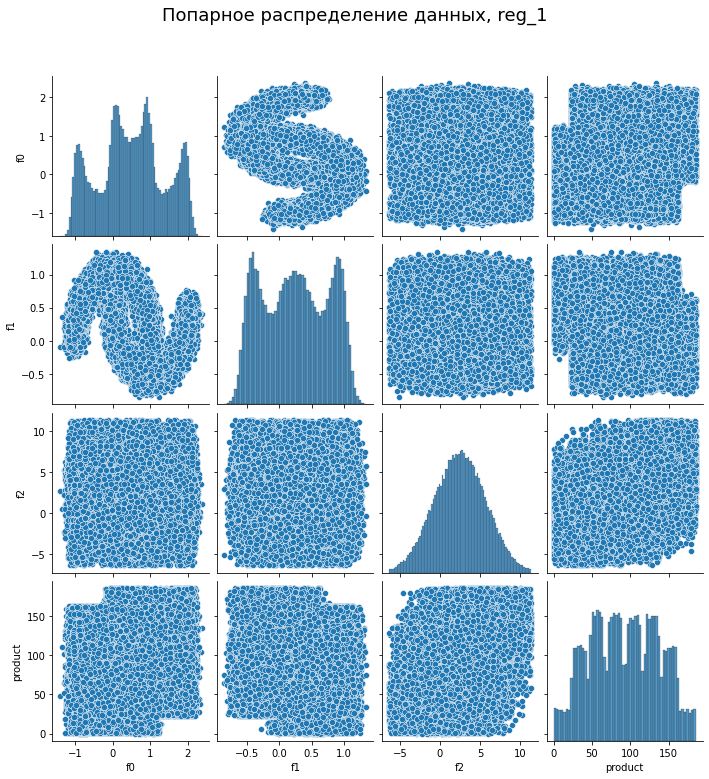

In [32]:
# проверяем попарное распределение данных в параметрах reg_1
g = sns.pairplot(data=data_1)
g.fig.suptitle('Попарное распределение данных, reg_1'\
               , y=1.08, fontsize=18);

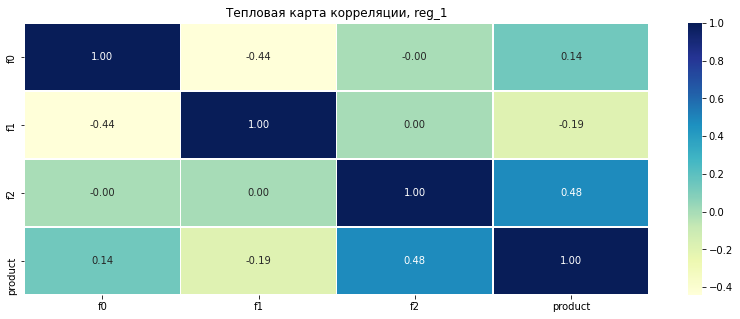

In [33]:
# строим тепловую карту корреляции reg_1
plt.figure(figsize=(14, 5)) 
heatmap = sns.heatmap(data_1.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGnBu") 
heatmap.set_title('Тепловая карта корреляции, reg_1', fontsize=12);

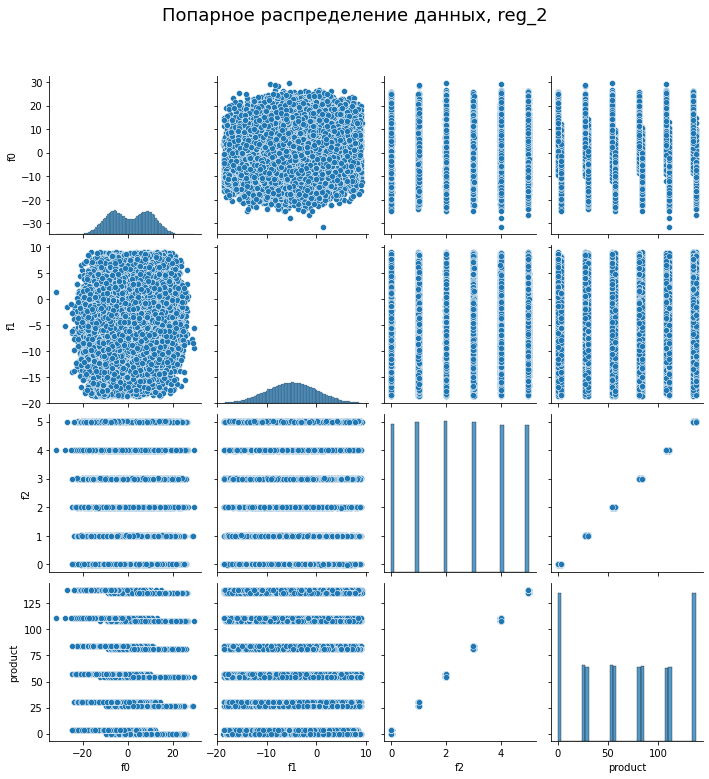

In [34]:
# проверяем попарное распределение данных в параметрах reg_2
g = sns.pairplot(data=data_2)
g.fig.suptitle('Попарное распределение данных, reg_2'\
               , y=1.08, fontsize=18);

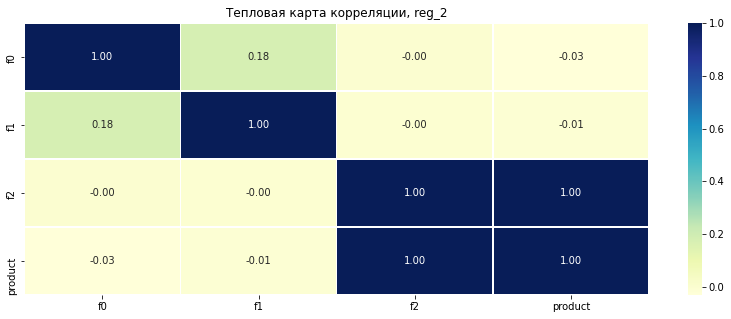

In [35]:
# строим тепловую карту корреляции reg_2
plt.figure(figsize=(14, 5)) 
heatmap = sns.heatmap(data_2.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGnBu") 
heatmap.set_title('Тепловая карта корреляции, reg_2', fontsize=12);

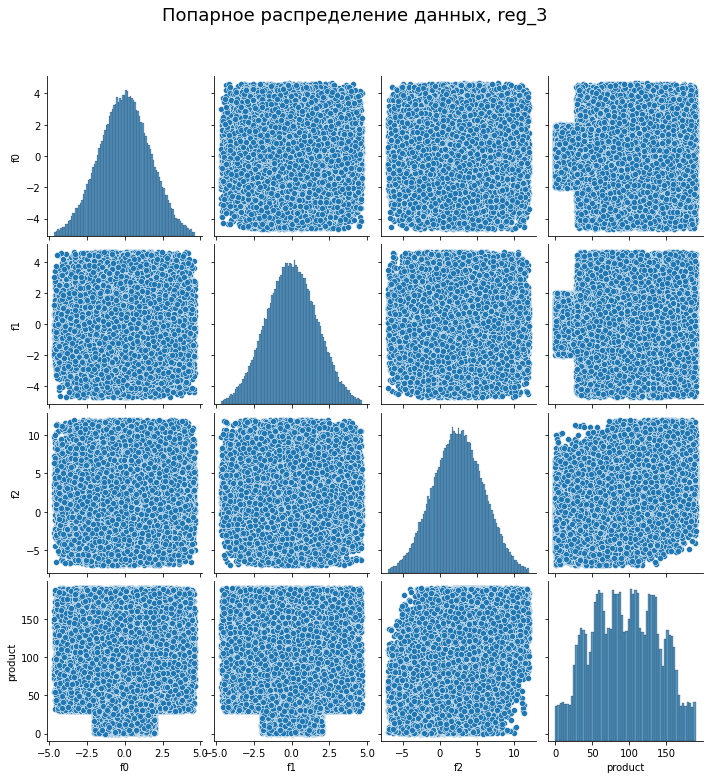

In [36]:
# проверяем попарное распределение данных в параметрах reg_3
g = sns.pairplot(data=data_3)
g.fig.suptitle('Попарное распределение данных, reg_3'\
               , y=1.08, fontsize=18);

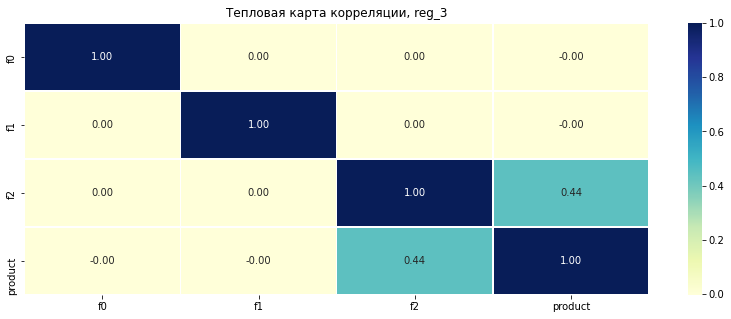

In [37]:
# строим тепловую карту корреляции reg_3
plt.figure(figsize=(14, 5)) 
heatmap = sns.heatmap(data_3.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGnBu") 
heatmap.set_title('Тепловая карта корреляции, reg_3', fontsize=12);

##### Выводы
* абсолютная линейная зависимость выявлена в регионе 2 между параметром f2 и целевой перменной
* в остальных регионах линейных зависимостей не выявлено

## Обучение и проверка модели

### регион 1

In [38]:
# удаляем из датасета парметр id
data_1 = data_1.drop('id', axis = 1)

In [39]:
# делим данные на признаки (матрица X) и целевую переменную (y)
# проверяем количество измерений 
X_1 = data_1.drop('product', axis=1)
y_1 = data_1['product']
print(X_1.shape)
print(y_1.shape)

(99473, 3)
(99473,)


In [40]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(
    X_1, y_1, test_size=0.25, random_state= RANDOM_STATE
)

In [41]:
# проверяем количество измерений в выборках
print(X_1_train.shape)
print(y_1_train.shape)
print(X_1_valid.shape)
print(y_1_valid.shape)

(74604, 3)
(74604,)
(24869, 3)
(24869,)


In [42]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_1_train)
X_1_train_st = scaler.transform(X_1_train)
X_1_valid_st = scaler.transform(X_1_valid)

In [43]:
# задаем алгоритм и обучаем модель
model_1_lr = LinearRegression()
model_1_lr.fit(X_1_train_st, y_1_train)

LinearRegression()

In [44]:
# делаем предсказания обученной моделью
predictions_1_lr = model_1_lr.predict(X_1_valid_st)

In [45]:
# проверяем метрику RMSE на валидационной выборке,
# выводим средний запас по региону,
# выводим средний запас по ТОП 500 скважин в регионе
print("REG_1 valid RMSE: {}".format(mean_squared_error(y_1_valid, predictions_1_lr, squared=False)))
print("REG_1 средний запас: {}".format(predictions_1_lr.mean()))
predictions_1_top_500 = pd.Series(predictions_1_lr).sort_values(ascending=False).head(500)
print("REG_1 средний запас ТОП 500 скважин предсказание: {}".format(predictions_1_top_500.mean()))
y_valid_1_top_500 = pd.Series(y_1_valid).sort_values(ascending=False).head(500)
print("REG_1 средний запас ТОП 500 скважин исследование: {}".format(y_valid_1_top_500.mean()))

REG_1 valid RMSE: 37.72034580348119
REG_1 средний запас: 92.57710213053869
REG_1 средний запас ТОП 500 скважин предсказание: 145.91276162515393
REG_1 средний запас ТОП 500 скважин исследование: 180.10568035841703


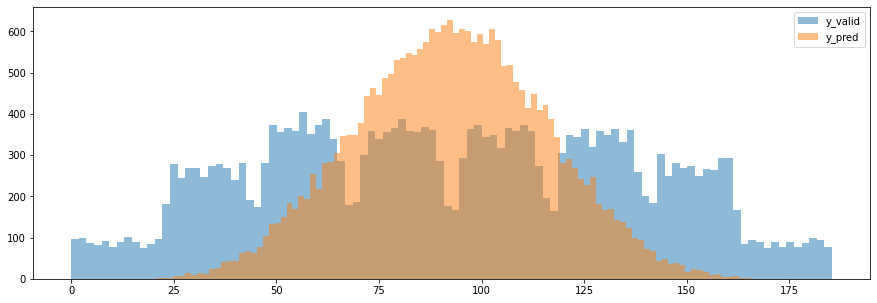

In [46]:
# строим гистрограммы распределения целевой переменной вылидационной выборки
# и предсказанных значений
plt.figure(figsize=(15, 5))
plt.hist(y_1_valid, bins=100, alpha = 0.5, label = 'y_valid')
plt.hist(predictions_1_lr, bins=100, alpha = 0.5, label = 'y_pred')
plt.legend();

### регион 2

In [47]:
# удаляем из датасета парметр id
data_2 = data_2.drop('id', axis = 1)

In [48]:
# делим данные на признаки (матрица X) и целевую переменную (y)
# проверяем количество измерений 
X_2 = data_2.drop('product', axis=1)
y_2 = data_2['product']
print(X_2.shape)
print(y_2.shape)

(99356, 3)
(99356,)


In [49]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(
    X_2, y_2, test_size=0.25, random_state= RANDOM_STATE
)

In [50]:
# проверяем количество измерений в выборках
print(X_2_train.shape)
print(y_2_train.shape)
print(X_2_valid.shape)
print(y_2_valid.shape)

(74517, 3)
(74517,)
(24839, 3)
(24839,)


In [51]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_2_train)
X_2_train_st = scaler.transform(X_2_train)
X_2_valid_st = scaler.transform(X_2_valid)

In [52]:
# задаем алгоритм и обучаем модель
model_2_lr = LinearRegression()
model_2_lr.fit(X_2_train_st, y_2_train)

LinearRegression()

In [53]:
# делаем предсказания обученной моделью
predictions_2_lr = model_2_lr.predict(X_2_valid_st)

In [54]:
# проверяем метрику RMSE на валидационной выборке,
# выводим средний запас по региону,
# выводим средний запас по ТОП 500 скважин в регионе
print("REG_2 valid RMSE: {}".format(mean_squared_error(y_2_valid, predictions_2_lr, squared=False)))
print("REG_2 средний запас предсказание: {}".format(predictions_2_lr.mean()))
predictions_2_top_500 = pd.Series(predictions_2_lr).sort_values(ascending=False).head(500)
print("REG_2 средний запас ТОП 500 скважин предсказание: {}".format(predictions_2_top_500.mean()))
y_valid_2_top_500 = pd.Series(y_2_valid).sort_values(ascending=False).head(500)
print("REG_2 средний запас ТОП 500 скважин исследование: {}".format(y_valid_2_top_500.mean()))

REG_2 valid RMSE: 0.8948190444437452
REG_2 средний запас предсказание: 69.01125116859164
REG_2 средний запас ТОП 500 скважин предсказание: 138.41294318794627
REG_2 средний запас ТОП 500 скважин исследование: 137.94540774090567


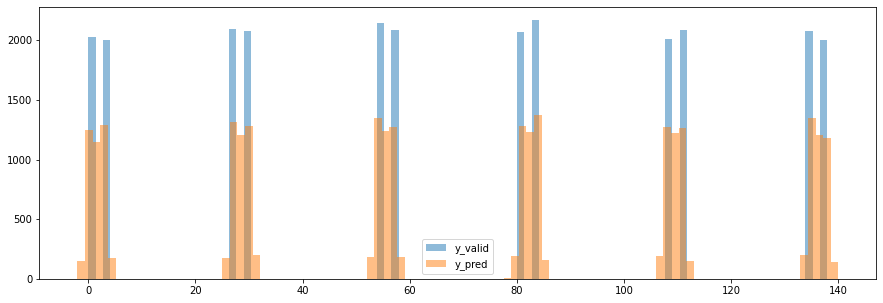

In [55]:
# строим гистрограммы распределения целевой переменной вылидационной выборки
# и предсказанных значений
plt.figure(figsize=(15, 5))
plt.hist(y_2_valid, bins=100, alpha = 0.5, label = 'y_valid')
plt.hist(predictions_2_lr, bins=100, alpha = 0.5, label = 'y_pred')
plt.legend();

### регион 3

In [56]:
# удаляем из датасета парметр id
data_3 = data_3.drop('id', axis = 1)

In [57]:
# делим данные на признаки (матрица X) и целевую переменную (y)
# проверяем количество измерений 
X_3 = data_3.drop('product', axis=1)
y_3 = data_3['product']
print(X_3.shape)
print(y_3.shape)

(97995, 3)
(97995,)


In [58]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_3_train, X_3_valid, y_3_train, y_3_valid = train_test_split(
    X_3, y_3, test_size=0.25, random_state= RANDOM_STATE
)

In [59]:
# проверяем количество измерений в выборках
print(X_3_train.shape)
print(y_3_train.shape)
print(X_3_valid.shape)
print(y_3_valid.shape)

(73496, 3)
(73496,)
(24499, 3)
(24499,)


In [60]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_3_train)
X_3_train_st = scaler.transform(X_3_train)
X_3_valid_st = scaler.transform(X_3_valid)

In [61]:
# задаем алгоритм и обучаем модель
model_3_lr = LinearRegression()
model_3_lr.fit(X_3_train_st, y_3_train)

LinearRegression()

In [62]:
# делаем предсказания обученной моделью
predictions_3_lr = model_3_lr.predict(X_3_valid_st)

In [63]:
# проверяем метрику RMSE на валидационной выборке,
# выводим средний запас по региону,
# выводим средний запас по ТОП 500 скважин в регионе
print("REG_3 valid RMSE: {}".format(mean_squared_error(y_3_valid, predictions_3_lr, squared=False)))
print("REG_3 средний запас: {}".format(predictions_3_lr.mean()))
predictions_3_top_500 = pd.Series(predictions_3_lr).sort_values(ascending=False).head(500)
print("REG_3 средний запас ТОП 500 скважин: {}".format(predictions_3_top_500.mean()))
y_valid_3_top_500 = pd.Series(y_3_valid).sort_values(ascending=False).head(500)
print("REG_3 средний запас ТОП 500 скважин исследование: {}".format(y_valid_3_top_500.mean()))

REG_3 valid RMSE: 40.38531541118843
REG_3 средний запас: 94.70800241097965
REG_3 средний запас ТОП 500 скважин: 140.31285736786143
REG_3 средний запас ТОП 500 скважин исследование: 184.7967162777674


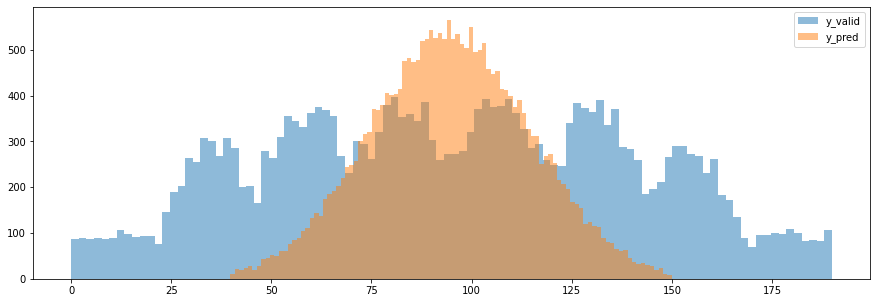

In [64]:
# строим гистрограммы распределения целевой переменной вылидационной выборки
# и предсказанных значений
plt.figure(figsize=(15, 5))
plt.hist(y_3_valid, bins=100, alpha = 0.5, label = 'y_valid')
plt.hist(predictions_3_lr, bins=100, alpha = 0.5, label = 'y_pred')
plt.legend();

**Сводная таблица по результатам работы модели на данных регионов:**

In [65]:
# строим сводную таблицу по результатам работы модели в регионах
results_valid = pd.DataFrame(columns=(['region', 'rmse_metrcis', 'top500_mean_predicted_volume', 'mean_predicted_volume']))
results_valid.region = ['reg_1', 'reg_2', 'reg_3']
results_valid.rmse_metrcis = ['37.72034580348119', '0.8948190444437452', '40.38531541118843']
results_valid.mean_predicted_volume = ['92.57710213053869', '69.01125116859164', '94.70800241097965']
results_valid.top500_mean_predicted_volume = ['145.91276162515393', '138.41294318794627', '140.31285736786143']

cm = sns.light_palette("blue", as_cmap=True)
display(results_valid.style.background_gradient(cmap=cm))

,region,rmse_metrcis,top500_mean_predicted_volume,mean_predicted_volume
0,reg_1,37.72034580348119,145.91276162515393,92.57710213053869
1,reg_2,0.8948190444437452,138.41294318794627,69.01125116859164
2,reg_3,40.38531541118843,140.31285736786143,94.70800241097965


### Выводы
* для решения задачи регресси была применена модель линейной регрессии как наиболее предсказуемая
* данные масштабированы
* на первое место по показателю метрики RMSE вышел регион 2, но при этом в регионе самые низкие ожидания по запасам
* на второе место по показателю метрики RMSE вышел регион 1, при этом показав лучшие ожидания по  предсказанным средним запасам ТОП 500 скважин
* на первое место по предсказанному среднему запасу вышел регион 3

## Подготовка к расчёту прибыли

In [66]:
# создаем переменные для ключевых значений расчетов
BUDGET_PER_REGION = 10_000_000_000
PRE_MAX_BOREHOLES = 500
FINAL_MAX_BOREHOLES = 200
REVENUE_PER_MIL_BARREL = 450_000
LOSS_THRESHOLD =  0.025

In [67]:
# делаем расчет безубыточного объема запасов одной скважины
BREAKEVEN_VOLUME_BOREHOLE = BUDGET_PER_REGION / REVENUE_PER_MIL_BARREL / FINAL_MAX_BOREHOLES
BREAKEVEN_VOLUME_REG = BUDGET_PER_REGION / REVENUE_PER_MIL_BARREL
print('Безубыточный объем запаса скважины:', BREAKEVEN_VOLUME_BOREHOLE)
print('Безубыточный объем запаса региона:', BREAKEVEN_VOLUME_REG)

Безубыточный объем запаса скважины: 111.11111111111111
Безубыточный объем запаса региона: 22222.222222222223


In [68]:
# выводим стат данные по целевой перменной product в регионах
statistics_product_r1 = data_1['product'].describe().to_frame()
statistics_product_r2 = data_2['product'].describe().to_frame()
statistics_product_r3 = data_3['product'].describe().to_frame()
statistics_product = statistics_product_r1.join(statistics_product_r2, rsuffix="_reg_2")\
.join(statistics_product_r3, rsuffix="_reg_3")
display(statistics_product)

,product,product_reg_2,product_reg_3
count,99473.000000,99356.000000,97995.000000
mean,92.500765,68.809060,94.783796
std,44.228930,45.935409,44.683066
min,0.000000,0.000000,0.000000
25%,56.565401,26.953261,59.330119
50%,91.842280,57.085625,94.695386
75%,128.518797,107.813044,130.317309
max,185.364347,137.945408,190.029838


### Выводы
* расчет порога безубыточности показал, что для скважины он составляет 111 тыс. баррелей, для региона 22 222 тыс. баррелей
* исходя из оценки среднего и медианы:
>
> 25% скважин находятся в зоне безубыточности в регионах 1 и 3
>
> регион 2 имеет показатель ниже 25%
>

## Расчёт прибыли и рисков 

In [69]:
# создаем функцию расчета прибыли
def income(target_true, target_pred):
    y_pred_max200 = pd.Series(target_pred).sort_values(ascending=False)[:FINAL_MAX_BOREHOLES]
    y_true_max200 = (target_true.reset_index(drop = True)[y_pred_max200.index])
    true_sum = y_true_max200.sum()
    return round((true_sum * REVENUE_PER_MIL_BARREL) - BUDGET_PER_REGION, 2)

In [70]:
# выводим результаты расчета прибыли по регионам
print('Прибыль с лучших 200 скважин в регионе 1:', income(y_1_valid, predictions_1_lr))
print('Прибыль с лучших 200 скважин в регионе 2:', income(y_2_valid, predictions_2_lr))
print('Прибыль с лучших 200 скважин в регионе 3:', income(y_3_valid, predictions_3_lr))

Прибыль с лучших 200 скважин в регионе 1: 3446969895.69
Прибыль с лучших 200 скважин в регионе 2: 2415086696.68
Прибыль с лучших 200 скважин в регионе 3: 2018477475.58


In [71]:
# строим функцию расчета средней прибыли, риска и доверительного интервала
# с применением техники Bootstrap с 1000 выборок
def confidence_interval(target_true, target_pred):
    samples = []
    for i in range(1000):
        sample = pd.Series(target_pred).sample(n = PRE_MAX_BOREHOLES, replace=True, random_state = RANDOM_STATE)
        samples.append(income(target_true, sample))
    samples = pd.Series(samples)
    print('Средняя прибыль ТОП 200 скважин:', samples.mean())
    print('Риск убытков:', samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [72]:
print("95% доверительный итервал для региона 1 ТОП 200 скважин лежит между:",
      confidence_interval(y_1_valid, predictions_1_lr))
print()
print("95% Доверительный итервал для региона 2 ТОП 200 скважин лежит между:",
      confidence_interval(y_2_valid, predictions_2_lr))
print()
print("95% Доверительный итервал для региона 3 ТОП 200 скважин лежит между:",
      confidence_interval(y_3_valid, predictions_3_lr))

Средняя прибыль ТОП 200 скважин: 385858651.30858004
Риск убытков: 6.9 %
95% доверительный итервал для региона 1 ТОП 200 скважин лежит между: (-93386650.82, 909536966.34)

Средняя прибыль ТОП 200 скважин: 430379153.23535997
Риск убытков: 2.0 %
95% Доверительный итервал для региона 2 ТОП 200 скважин лежит между: (22400620.03, 813131548.9)

Средняя прибыль ТОП 200 скважин: 300703722.17401993
Риск убытков: 13.5 %
95% Доверительный итервал для региона 3 ТОП 200 скважин лежит между: (-237500509.23, 863995125.31)


### Выводы
* согласно критериям проекта (вероятность убытков меньше 2.5%) только **регион 2** подходит для дальнейнешего рассмотрения разработки с точки зрения оценки **риска убытков - 2.0%**
* **регион 2** также показал **лучший результат** по ожиданиям **средней прибыли** ТОП 200 скважин: **430 379 153.23**
* **95% доверительный интервал региона 2** лежит в позитивном поле: от **22 400 620.03 до 813 131 548.9**
* в качестве **альтернативы и бэкапа** для дальнейшего рассмотрения и более глубокого анализа также предлагается рассмотерть **Регион 1** (/datasets/geo_data_0.csv) на основании следующих доводов: 
1. данные о результатах геологоразведки в регионе имеют **консистентный характер**
2. модель линейной регрессии, обученная для предсказания на данных региона, показала **адекватную метрику MRSE: 37.72**
3. **25% скважин находятся в зоне безубыточности**
3. регион показал **лучший результат по ожидаемой суммарной прибыли от ТОП 200 скважин: 3 446 969 895.69**